In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("final_project").getOrCreate()

In [2]:
spark

# load and explore data

In [18]:
df2004 = spark.read.csv("s3://jenova73/final/311_Service_Requests_for_2004.csv",
                      header = True, inferSchema= True)
df2005 = spark.read.csv("s3://jenova73/final/311_Service_Requests_for_2005.csv",
                      header = True, inferSchema= True)
df2006 = spark.read.csv("s3://jenova73/final/311_Service_Requests_for_2006.csv",
                      header = True, inferSchema= True)
df2007 = spark.read.csv("s3://jenova73/final/311_Service_Requests_for_2007.csv",
                      header = True, inferSchema= True)
df2008 = spark.read.csv("s3://jenova73/final/311_Service_Requests_for_2008.csv",
                      header = True, inferSchema= True)
df2009 = spark.read.csv("s3://jenova73/final/311_Service_Requests_for_2009.csv",
                      header = True, inferSchema= True)
df2010 = spark.read.csv("s3://jenova73/final/311_Service_Requests_from_2010_to_Present (1).csv",
                      header = True, inferSchema= True)

In [22]:
df2010 = spark.read.csv("s3://jenova73/final/311_Service_Requests_from_2010_to_Present (1).csv",
                      header = True, inferSchema= True)
df2010.printSchema()
df2004.printSchema()


root
 |-- Unique Key: integer (nullable = true)
 |-- Created Date: string (nullable = true)
 |-- Closed Date: string (nullable = true)
 |-- Agency: string (nullable = true)
 |-- Agency Name: string (nullable = true)
 |-- Complaint Type: string (nullable = true)
 |-- Descriptor: string (nullable = true)
 |-- Location Type: string (nullable = true)
 |-- Incident Zip: string (nullable = true)
 |-- Incident Address: string (nullable = true)
 |-- Street Name: string (nullable = true)
 |-- Cross Street 1: string (nullable = true)
 |-- Cross Street 2: string (nullable = true)
 |-- Intersection Street 1: string (nullable = true)
 |-- Intersection Street 2: string (nullable = true)
 |-- Address Type: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Landmark: string (nullable = true)
 |-- Facility Type: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- Due Date: string (nullable = true)
 |-- Resolution Description: string (nullable = true)
 |-- Resolution Actio

In [26]:
columns = ['Created Date','Closed Date','Agency','Agency Name',
          'Complaint Type','Descriptor','Location Type','Incident Zip',
          'City','Status','Community Board','Borough','Park Borough',
          'Latitude','Longitude']
df2011=df2010.select(*columns)

In [27]:
merged = df2004.union(df2005)
merged = merged.union(df2006)
merged = merged.union(df2007)
merged = merged.union(df2008)
merged = merged.union(df2009)
merged = merged.select(*columns)
merged = merged.union(df2011)


In [ ]:
data = merged
                    

In [30]:
data.printSchema()

root
 |-- Unique Key: integer (nullable = true)
 |-- Created Date: string (nullable = true)
 |-- Closed Date: string (nullable = true)
 |-- Agency: string (nullable = true)
 |-- Agency Name: string (nullable = true)
 |-- Complaint Type: string (nullable = true)
 |-- Descriptor: string (nullable = true)
 |-- Location Type: string (nullable = true)
 |-- Incident Zip: string (nullable = true)
 |-- Incident Address: string (nullable = true)
 |-- Street Name: string (nullable = true)
 |-- Cross Street 1: string (nullable = true)
 |-- Cross Street 2: string (nullable = true)
 |-- Intersection Street 1: string (nullable = true)
 |-- Intersection Street 2: string (nullable = true)
 |-- Address Type: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Landmark: string (nullable = true)
 |-- Facility Type: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- Due Date: string (nullable = true)
 |-- Resolution Action Updated Date: string (nullable = true)
 |-- Communit

In [31]:
data.count()

1118286

In [358]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DateType
from pyspark.sql.functions import to_timestamp
from pyspark.sql.types import StringType, IntegerType, FloatType

In [33]:
data.dropna()

DataFrame[Unique Key: int, Created Date: string, Closed Date: string, Agency: string, Agency Name: string, Complaint Type: string, Descriptor: string, Location Type: string, Incident Zip: string, Incident Address: string, Street Name: string, Cross Street 1: string, Cross Street 2: string, Intersection Street 1: string, Intersection Street 2: string, Address Type: string, City: string, Landmark: string, Facility Type: string, Status: string, Due Date: string, Resolution Action Updated Date: string, Community Board: string, Borough: string, X Coordinate (State Plane): int, Y Coordinate (State Plane): int, Park Facility Name: string, Park Borough: string, School Name: string, School Number: string, School Region: string, School Code: string, School Phone Number: string, School Address: string, School City: string, School State: string, School Zip: string, School Not Found: string, School or Citywide Complaint: string, Vehicle Type: string, Taxi Company Borough: string, Taxi Pick Up Locat

In [34]:
data.count()

1118286

### Data Cleaning

In [35]:
columns = ['Created Date','Closed Date','Agency','Agency Name',
          'Complaint Type','Descriptor','Location Type','Incident Zip',
          'City','Status','Community Board','Borough','Park Borough',
          'Latitude','Longitude']

In [36]:
data=data.select(*columns)

In [603]:
from pyspark.sql.functions import to_date, to_timestamp, datediff,year, month
df1=data.withColumn("start_date", to_date('Created Date','MM/dd/yyyy HH:mm:ss'))
df1=df1.withColumn("end_date", to_date('Closed Date','MM/dd/yyyy HH:mm:ss'))
df1=df1.withColumn('Time',datediff('end_date','start_date'))
df1= df1.withColumn('Timebin',F.when(df1.Time<3, 0).otherwise(F.when(df1.Time<6,1).otherwise(2)))
df1=df1.withColumn('Year',year('start_date'))
df1=df1.withColumn('Month',month('start_date'))
df1=df1.drop('Created Date','Closed Date','start_date','end_date','Time')


In [604]:
df1 = df1.withColumn("Timebin",col("Timebin").cast(StringType()))
df1 = df1.withColumn("Year",col("Year").cast(StringType()))
df1 = df1.withColumn("Month",col("Month").cast(StringType()))


In [605]:
df1.printSchema()

root
 |-- Agency: string (nullable = true)
 |-- Agency Name: string (nullable = true)
 |-- Complaint Type: string (nullable = true)
 |-- Descriptor: string (nullable = true)
 |-- Location Type: string (nullable = true)
 |-- Incident Zip: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- Community Board: string (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Park Borough: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Timebin: string (nullable = false)
 |-- Year: string (nullable = true)
 |-- Month: string (nullable = true)



# prepare data

In [606]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline, Model
import pandas as pd
import numpy as np
from pyspark.sql import functions as F
from pyspark.sql.functions import col

In [607]:
(train, test) = (df1.randomSplit([0.75,0.25]))

### change string or integer into index

In [608]:
df1.printSchema()

root
 |-- Agency: string (nullable = true)
 |-- Agency Name: string (nullable = true)
 |-- Complaint Type: string (nullable = true)
 |-- Descriptor: string (nullable = true)
 |-- Location Type: string (nullable = true)
 |-- Incident Zip: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- Community Board: string (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Park Borough: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Timebin: string (nullable = false)
 |-- Year: string (nullable = true)
 |-- Month: string (nullable = true)



In [609]:
df1=df1.drop('Longitude','Latitude')
df1=df1.dropna()

In [610]:
Agency_indexer = StringIndexer(inputCol = 'Agency',outputCol='Agency_index').setHandleInvalid("keep")
Agency_Name_indexer = StringIndexer(inputCol = 'Agency Name',outputCol='Agency_Name_index').setHandleInvalid("keep")
Complaint_Type_indexer = StringIndexer(inputCol = 'Complaint Type',outputCol='Complaint_Type_index').setHandleInvalid("keep")
Descriptor_indexer = StringIndexer(inputCol = 'Descriptor',outputCol='Descriptor_index').setHandleInvalid("keep")
Location_Type_indexer = StringIndexer(inputCol = 'Location Type',outputCol='Location_Type_index').setHandleInvalid("keep")
Incident_indexer = StringIndexer(inputCol = 'Incident Zip',outputCol='Incident_index').setHandleInvalid("keep")
City_indexer = StringIndexer(inputCol = 'City',outputCol='City_index').setHandleInvalid("keep")
Status_indexer = StringIndexer(inputCol = 'Status',outputCol='Status_index').setHandleInvalid("keep")
Community_Board_indexer = StringIndexer(inputCol = 'Community Board',outputCol='Community_Board_index')
Borough_indexer = StringIndexer(inputCol = 'Borough',outputCol='Borough_index').setHandleInvalid("keep")
Park_indexer= StringIndexer(inputCol = 'Park Borough',outputCol='Park_index').setHandleInvalid("keep")
Time_indexer = StringIndexer(inputCol = 'Timebin',outputCol='label').setHandleInvalid("keep")
Year_indexer = StringIndexer(inputCol = 'Year',outputCol='Year_index').setHandleInvalid("keep")
Month_indexer = StringIndexer(inputCol = 'Month',outputCol='Month_index').setHandleInvalid("keep")

In [611]:
assembler = VectorAssembler(inputCols = ["Agency_index", 
                                         "Agency_Name_index",
                                         "Complaint_Type_index",
                                         "Descriptor_index",
                                         "Location_Type_index",
                                         "Incident_index",
                                         "Status_index",
                                         "Borough_index",
                                         "Community_Board_index",
                                         "Park_index",'City_index',
                                        'Year_index','Month_index'],
                            outputCol = 'features')

### Logistics Regression

In [612]:
Logistic_regression_pipeline = Pipeline(stages=[Agency_indexer,
                                       Agency_Name_indexer,Complaint_Type_indexer,
                                     Descriptor_indexer,Location_Type_indexer,Incident_indexer,
                                     Status_indexer,Community_Board_indexer,Borough_indexer,
                                     Park_indexer,City_indexer,Timebin_indexer,Year_indexer,Month_indexer,
                                     assembler,
                                     LogisticRegression(featuresCol = 'features',labelCol = 'label')])

In [613]:
sample_train= train.limit(300).cache()

In [614]:
sample_train.printSchema()

root
 |-- Agency: string (nullable = true)
 |-- Agency Name: string (nullable = true)
 |-- Complaint Type: string (nullable = true)
 |-- Descriptor: string (nullable = true)
 |-- Location Type: string (nullable = true)
 |-- Incident Zip: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- Community Board: string (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Park Borough: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Timebin: string (nullable = false)
 |-- Year: string (nullable = true)
 |-- Month: string (nullable = true)



In [615]:
model_alpha = Logistic_regression_pipeline.fit(sample_train)

In [616]:
logistic_model = Logistic_regression_pipeline.fit(train)

In [617]:
prediction = logistic_model.transform(test)

In [618]:
evaluator = MulticlassClassificationEvaluator() 
print('F1-Score ', evaluator.evaluate(prediction, 
                                      {evaluator.metricName: 'f1'}))
print('Precision ', evaluator.evaluate(prediction,
                                       {evaluator.metricName:                    'weightedPrecision'}))
print('Recall ', evaluator.evaluate(prediction, 
                                    {evaluator.metricName: 'weightedRecall'}))
print('Accuracy ', evaluator.evaluate(prediction, 
                                      {evaluator.metricName: 'accuracy'}))

F1-Score  0.6201677917040486
Precision  0.6112959311328088
Recall  0.6607483922657071
Accuracy  0.6607483922657071


### Random Forest 

In [619]:
rf = RandomForestClassifier(featuresCol = 'features',labelCol = 'label',maxDepth=2,maxBins=1000)
paramGrid = ParamGridBuilder().addGrid(rf.maxBins, 
                                       [1000]).addGrid(rf.maxDepth, [8]).addGrid(rf.impurity, ["entropy", "gini"]).build()


In [620]:
rf_pipeline = Pipeline(stages=[Agency_indexer,
                                Agency_Name_indexer,Complaint_Type_indexer,
                                Descriptor_indexer,Location_Type_indexer,Incident_indexer,
                                     Status_indexer,Community_Board_indexer,Borough_indexer,
                                     Park_indexer,City_indexer,Timebin_indexer,Year_indexer,Month_indexer,
                                     assembler,rf])

In [621]:
rf_model = rf_pipeline.fit(train)

In [622]:
rf_prediction = rf_model.transform(test)

In [623]:
evaluator = MulticlassClassificationEvaluator() 
print('F1-Score ', evaluator.evaluate(rf_prediction, 
                                      {evaluator.metricName: 'f1'}))
print('Precision ', evaluator.evaluate(rf_prediction,
                                       {evaluator.metricName:                    'weightedPrecision'}))
print('Recall ', evaluator.evaluate(rf_prediction, 
                                    {evaluator.metricName: 'weightedRecall'}))
print('Accuracy ', evaluator.evaluate(rf_prediction, 
                                      {evaluator.metricName: 'accuracy'}))

F1-Score  0.6628416213713252
Precision  0.6228873993908598
Recall  0.7085261779917449
Accuracy  0.7085261779917449


In [624]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix


In [625]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [626]:
ytrue = prediction.select('label')
ytrue = ytrue.toPandas()

ypred = prediction.select('prediction')
ypred = ypred.toPandas()


In [639]:
ypred.describe()

,prediction
count,279586.000000
mean,0.473600
std,0.499303
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [631]:
cnf_matrix = confusion_matrix(ytrue, ypred,labels=range(3))

In [632]:
cnf_matrix

array([[94707, 37554,   136],
       [22988, 89987,    80],
       [ 9799, 24293,    42]])

Normalized confusion matrix
[[7.15325876e-01 2.83646910e-01 1.02721361e-03]
 [2.03334660e-01 7.95957720e-01 7.07620185e-04]
 [2.87074471e-01 7.11695084e-01 1.23044472e-03]]


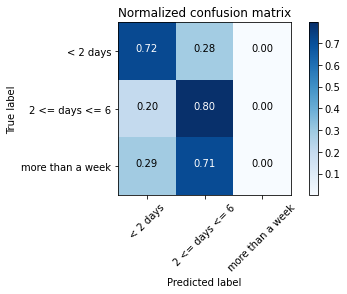

In [633]:
class_names = ['< 2 days','2 <= days <= 6','more than a week',]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Logistic confusion matrix')
plt.show()

In [634]:
ytrue = rf_prediction.select('label')
ytrue = ytrue.toPandas()

ypred = rf_prediction.select('prediction')
ypred = ypred.toPandas()



In [638]:
cnf_matrix = confusion_matrix(ytrue, ypred,)
cnf_matrix

array([[109550,  22847,      0],
       [ 24511,  88544,      0],
       [ 13113,  21021,      0]])

Normalized confusion matrix
[[0.82743567 0.17256433 0.        ]
 [0.21680598 0.78319402 0.        ]
 [0.38416242 0.61583758 0.        ]]


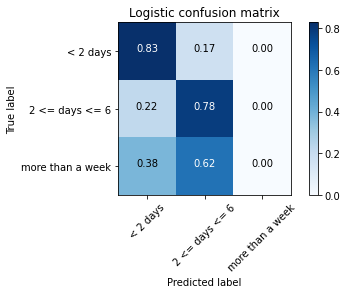

In [636]:
class_names = ['< 2 days','2 <= days <= 6','more than a week',]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Logistic confusion matrix')
plt.show()